### Determining Optimal Probability Cutoff

Predicted proabability is a number between 0 and 1. Traditionally >.5 is the cutoff point used for converting predicted proabability to 1 (positive) otherwise 0 (negative). This logic works well when your training data set has equal example of positive and negative cases, however this is not the case in real world scenarios. 

#### Solution:
The solution is to find the optimal cut off point, that is the point where true positive rate is high and the false positive rate is low. Anything above this threold can be labeled as 1 else 0. Let's understand this better with an example. 

#### Dataset

We'll be using the dataset from the UCI repository, dataset "Pima Indian diabetes": 
2 classes, 8 attributes, 768 instances, 500 (65.1%) negative (class1), and 268 (34.9%) positive tests for diabetes. class2. 
All patients were females at least 21 years old of Pima Indian heritage.

Attributes used: 
1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years)

In [1]:
import pandas as pd
import pylab as plt
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# read the data in
df = pd.read_csv("Data/Diabetes.csv")
df.head()

# target variable % distribution
print df['class'].value_counts(normalize=True)

X = df.ix[:,:8]     # independent variables
y = df['class']     # dependent variables

0    0.651042
1    0.348958
Name: class, dtype: float64


In [3]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# instantiate a logistic regression model, and fit 
model = LogisticRegression()
model = model.fit(X_train, y_train)

# predict class labels for the train set. The predict fuction converts probability values > .5 to 1 else 0
y_pred = model.predict(X_train)

# generate class probabilities 
# Notice that 2 elements will be returned in probs array, 
# 1st element is probability for negative class,
# 2nd element gives probability for positive class
probs = model.predict_proba(X_train)
y_pred_prob = probs[:, 1]

# generate evaluation metrics
print "Accuracy: ", metrics.accuracy_score(y_train, y_pred)

Accuracy:  0.767225325885


The optimal cut off would be where tpr is high and fpr is low, and tpr - (1-fpr) is zero or near to zero

Area under the ROC curve : 0.833113


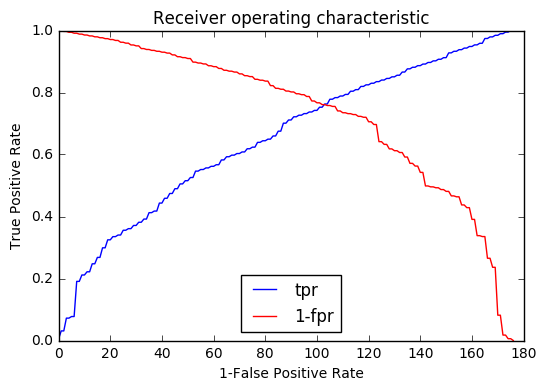

In [4]:
# extract false positive, true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), 
                    '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 
                    'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'], label='tpr')
plt.plot(roc['1-fpr'], color = 'red', label='1-fpr')
plt.legend(loc='best')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

To simplify finding optimal probability threshold and bring in re-usability, I have made a function to find the optimal probability cutoff point.

In [5]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [6]:
# Find optimal probability threshold
# Note: probs[:, 1] will have probability of being positive label
threshold = Find_Optimal_Cutoff(y_train, probs[:, 1])
print "Optimal Probability Threshold: ", threshold

# Applying the threshold to the prediction probability
y_pred_optimal = np.where(y_pred_prob >= threshold, 1, 0)

# Let's compare the accuracy of traditional/normal approach vs optimal cutoff
print "\nNormal - Accuracy: ", metrics.accuracy_score(y_train, y_pred)
print "Optimal Cutoff - Accuracy: ", metrics.accuracy_score(y_train, y_pred_optimal)
print "\nNormal - Confusion Matrix: \n", metrics.confusion_matrix(y_train, y_pred)
print "Optimal - Cutoff Confusion Matrix: \n", metrics.confusion_matrix(y_train, y_pred_optimal)

Optimal Probability Threshold:  [0.36133240553264734]

Normal - Accuracy:  0.767225325885
Optimal Cutoff - Accuracy:  0.761638733706

Normal - Confusion Matrix: 
[[303  40]
 [ 85 109]]
Optimal - Cutoff Confusion Matrix: 
[[261  82]
 [ 46 148]]


Notice that there is no significant difference in overall accuracy between normal vs. optimal cutoff method, both are 76%. However there is 36% increase in true positive rate in optimal cutoff method i.e., you are now able to capture 36% more positive cases as positive, also the false positive has doubled i..e, probability of predicting an individual not having diabetes as positive has increase.

### Which error is costly?

Well, there is no one answer for this questoin! It depends on the domain, problem that you are trying to address and the business requirement. In our case comparatively type II error might be more damaging than type I error.

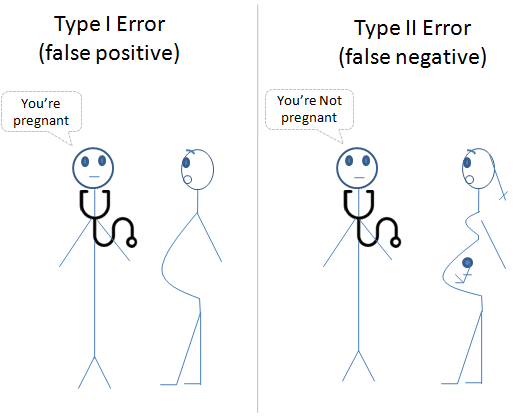

In [7]:
from IPython.display import Image
Image(filename='../Chapter 4 Figures/Error_Type.png', width=500)